In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image
from random import randint

In [2]:
df = pd.read_csv("spamPromotion_detection/training_set.csv")

In [3]:
df["image"] = df["PromotionId"].copy()

for n in range(len(df)):
    df["image"][n] += ".jpg"

In [4]:
df

,PromotionId,description,bad,image
0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T.jpg
1,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5.jpg
2,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq.jpg
3,1NWLC9rEila7y7EyYKPp17zCMkjHs2,สาวกเพื่อสุขภาพครับ,1,1NWLC9rEila7y7EyYKPp17zCMkjHs2.jpg
4,1NWLCUe1qEBZtZEwInmjdBoce8XBF2,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0,1NWLCUe1qEBZtZEwInmjdBoce8XBF2.jpg
...,...,...,...,...
2100,1NWL9v9ua9oLaFs779duFoI9ft0fga,อิ่มคุ้ม สบายกระเป๋า กับชุด Super Save จับคู่ ...,0,1NWL9v9ua9oLaFs779duFoI9ft0fga.jpg
2101,1NWLBrPfc24ETTz9QzE8Ve51n6jigw,NaN,0,1NWLBrPfc24ETTz9QzE8Ve51n6jigw.jpg
2102,1NWLBCWHKnRCd94ttE5Ax5L1fYKaTE,หมูนุ่มน้ำมันงา นุ่มละมุน ละลายในปาก หอมน้ำมัน...,1,1NWLBCWHKnRCd94ttE5Ax5L1fYKaTE.jpg
2103,1NWLCG2dgzDFbbPtmjzv4n1GyNgdnb,NaN,1,1NWLCG2dgzDFbbPtmjzv4n1GyNgdnb.jpg


In [5]:
df.to_csv("spamPromotion_detection/train.csv", index=False)

In [6]:
WORK_DIR = "spamPromotion_detection"
label_col = "PromotionId"
img_col = "image"
training_images = "training_images"
testing_images = "testing_images"
os.listdir(WORK_DIR)

['testing_images',
 'testing_set.csv',
 'train.csv',
 'training_images',
 'training_set.csv']

In [7]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, training_images))))

Train images: 2106


In [8]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
label_names = train_labels[label_col].value_counts().index
label_map = {name:i for (i,name) in enumerate(label_names)}
inv_label_map = {v: k for k, v in label_map.items()}
display(train_labels.head())

train_labels[label_col] = train_labels[label_col].map(label_map)
display(train_labels.head())

,PromotionId,description,bad,image
0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T.jpg
1,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5.jpg
2,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq.jpg
3,1NWLC9rEila7y7EyYKPp17zCMkjHs2,สาวกเพื่อสุขภาพครับ,1,1NWLC9rEila7y7EyYKPp17zCMkjHs2.jpg
4,1NWLCUe1qEBZtZEwInmjdBoce8XBF2,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0,1NWLCUe1qEBZtZEwInmjdBoce8XBF2.jpg


,PromotionId,description,bad,image
0,0,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T.jpg
1,1053,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5.jpg
2,1413,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq.jpg
3,1412,สาวกเพื่อสุขภาพครับ,1,1NWLC9rEila7y7EyYKPp17zCMkjHs2.jpg
4,1411,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0,1NWLCUe1qEBZtZEwInmjdBoce8XBF2.jpg


In [9]:
train_labels["label"] = train_labels["bad"].apply(lambda score: "spam" if score == 1 else "ham")
train_labels

,PromotionId,description,bad,image,label
0,0,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T.jpg,ham
1,1053,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5.jpg,ham
2,1413,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq.jpg,spam
3,1412,สาวกเพื่อสุขภาพครับ,1,1NWLC9rEila7y7EyYKPp17zCMkjHs2.jpg,spam
4,1411,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0,1NWLCUe1qEBZtZEwInmjdBoce8XBF2.jpg,ham
...,...,...,...,...,...
2100,697,อิ่มคุ้ม สบายกระเป๋า กับชุด Super Save จับคู่ ...,0,1NWL9v9ua9oLaFs779duFoI9ft0fga.jpg,ham
2101,696,NaN,0,1NWLBrPfc24ETTz9QzE8Ve51n6jigw.jpg,ham
2102,695,หมูนุ่มน้ำมันงา นุ่มละมุน ละลายในปาก หอมน้ำมัน...,1,1NWLBCWHKnRCd94ttE5Ax5L1fYKaTE.jpg,spam
2103,694,NaN,1,1NWLCG2dgzDFbbPtmjzv4n1GyNgdnb.jpg,spam


In [10]:
BATCH_SIZE = 8
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 4
TARGET_SIZE = 512

In [11]:
train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, training_images),
                         subset = "training",
                         x_col = img_col,
                         y_col = label_col,
                         color_mode='grayscale',
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "raw")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, training_images),
                         subset = "validation",
                         color_mode='grayscale',
                         x_col = img_col,
                         y_col = label_col,
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "raw")

Found 1684 validated image filenames.
Found 421 validated image filenames.


In [12]:
def plot_from_generator(train_generator, label_names, n=5):
    for _ in range(n):
        batch_num = randint(0, len(train_generator))
        bach_element = randint(0, BATCH_SIZE-1)

        batch = train_generator[batch_num]
        aug_images = [i/ 255 for i in batch[0]]
        aug_labels = list(batch[1])

        fig, axes = plt.subplots(1, 5, figsize = (20, 10))
        axes = axes.flatten()
        for img, lbl, ax in zip(aug_images, aug_labels, axes):
            img = np.squeeze(img)
            ax.imshow(img)
            ax.set_title(lbl)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

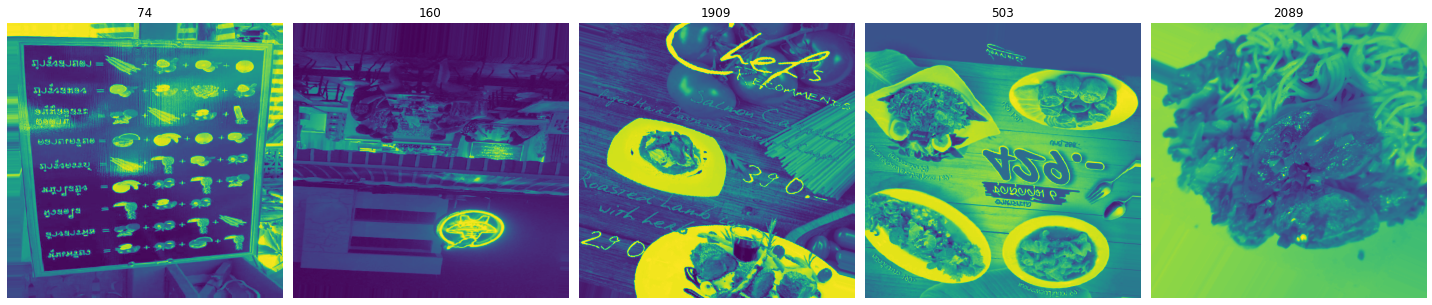

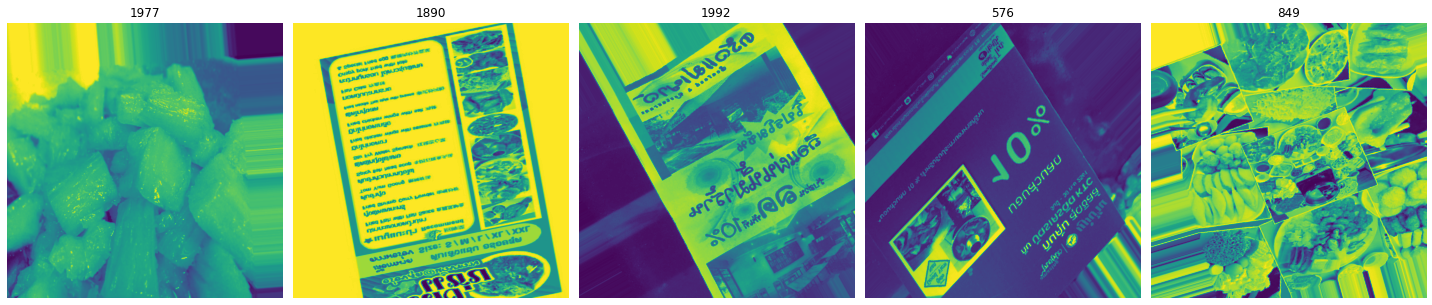

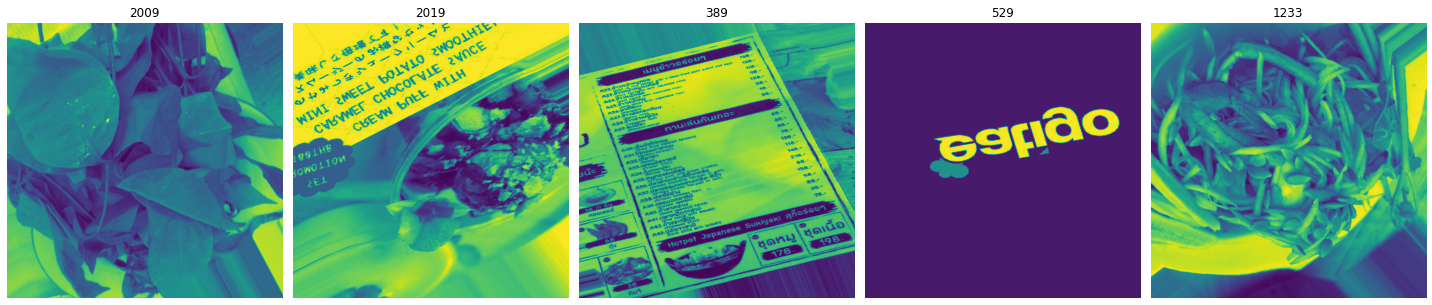

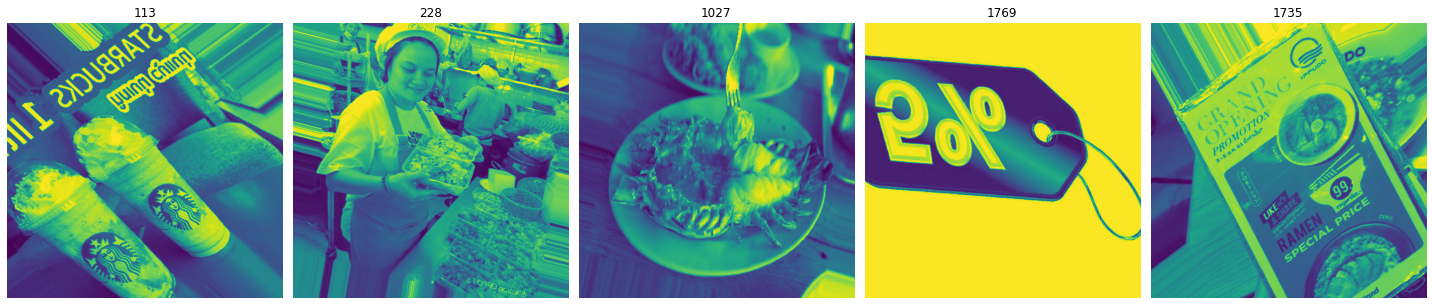

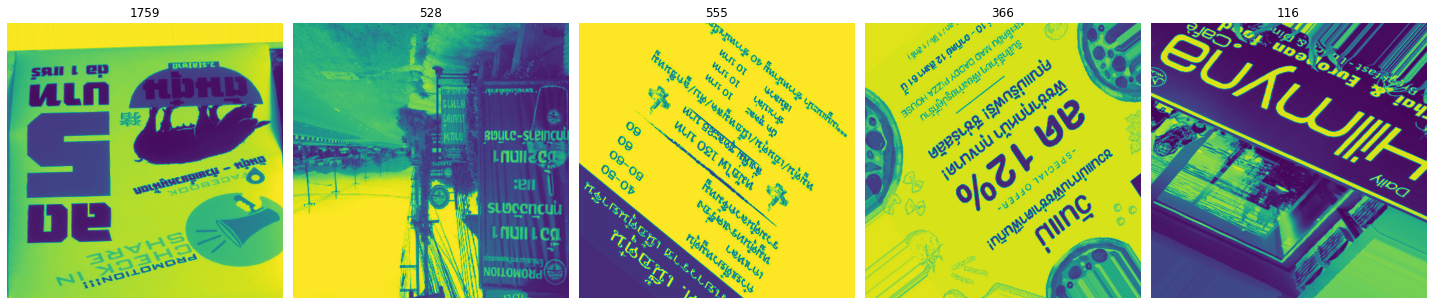

In [13]:
plot_from_generator(train_generator, label_names, n=5)

In [14]:
def create_model():
    conv_base = EfficientNetB7(include_top = False, weights = None,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 1))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(len(label_names)+1, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [15]:
model = create_model()
#model.summary()

In [16]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

Our EfficientNet CNN has 815 layers


In [ ]:
model_name = './EffNetB0_512_8_best_weights.h5'
model_save = ModelCheckpoint(model_name, 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

 
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/4
 11/210 [>.............................] - ETA: 9:48:58 - loss: 8.1814 - acc: 0.0000e+00